# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Imports and creating Spark Session
import findspark
findspark.init()

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql import *
%matplotlib inline



spark = SparkSession.builder.getOrCreate()

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [2]:
# Load the dataset from json
# Later, load data from parquet

#DATA_DIR = 'data/'
#so_data = spark.read.json(DATA_DIR+'Posts.json')
#so_data.write.mode('overwrite').parquet('data.parquet')

# load data from parquet
so_data0 = spark.read.parquet("data.parquet")

In [3]:
# Clean data
so_data0.registerTempTable('so_data')
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Function to change date format to timestamp in seconds (typed as double)
format_date = udf(lambda z: datetime.strptime(z[:-3] + z[-2:], "%Y-%m-%dT%H:%M:%S.%f%z").timestamp(), DoubleType())
# Apply format_date function
so_data = so_data0.select(format_date('CreationDate').alias('CreationDate'), 'Id', 'ParentId', 'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount')
so_data.show(3)

+----------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|    CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+----------------+--------+--------+----------+-----+--------------------+--------------------+---------+
| 1.50297961718E9|45740344|45740224|         2|    0|                null|                null|     null|
| 1.50297962572E9|45740346|45739185|         2|    1|                null|                null|     null|
|1.502979628873E9|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
+----------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



___
1) How many questions have been asked on StackOverflow?

In [4]:
# We know that questions have a post-id = 1, so we use this to filter our questions
questions = so_data.filter('PostTypeId = 1')
n_questions = questions.count()
print('Number of questions: '+str(n_questions))

Number of questions: 15647060


___
2) How many answers have been given?

In [5]:
# We know that answers have a post-id = 2, so we use this to filter our answers
answers = so_data.filter('PostTypeId = 2')
n_answers = answers.count()
print('Number of answers: '+str(n_answers))

Number of answers: 25192772


___
3) What is the percentage of questions with a score of 0?

In [6]:
n_q_score0 = questions.filter('Score = 0').count()
print('Percentage of questions with a score of 0: ' + str(round(100*n_q_score0/n_questions,2))+ '%')

Percentage of questions with a score of 0: 46.54%


We can see that there are more responses than questions, which is a good thing. Many questions get 0 score, which could be becuase they are bad questions, or they are very specific and no one else is looking at them.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [7]:
# only look at tags
tags = questions.select('Tags')

In [8]:
# split the tags and count occurences
tags = questions.select('Tags')
tags = tags.select(f.split(tags.Tags,'><').alias('tag_names'), 
            f.posexplode(f.split(tags.Tags,'><')).alias('pos', 'val')).drop('tag_names','pos')\
            .withColumn('val',f.regexp_replace('val','<|>',''))\
            .groupBy('val').agg({"*": "count"})  

tags.show(3)

+------------+--------+
|         val|count(1)|
+------------+--------+
|   arguments|    7157|
|      iframe|   26125|
|google-earth|     816|
+------------+--------+
only showing top 3 rows



___
1) What is the proportion of tags that appear in fewer than 100 questions?

In [9]:
# Proportion = [number of tags in less than 100 questions] / [total number of tags]
prop_100_q = (tags.filter('count(1) < 100').groupBy().count().collect()[0][0]) / \
            (tags.groupBy().count().collect()[0][0])
print('Proportion of tags with less than 100 questions: ' + str(round(100*prop_100_q,2))+ '%')

Proportion of tags with less than 100 questions: 67.98%


We can see that most of the tags are only used for less than 100 questions, probably because many tags are very specific. The most likely reason for this is that users can create tags themselves, so many tags are created that are very specific. 
<a href="https://stackoverflow.com/help/privileges/create-tags">Information source</a>

_________
2) Plot the distribution of the tag counts using an appropriate representation.

In [10]:
# pass the dataframe to pandas to be able to plot the data
tag_pandas = tags.toPandas()

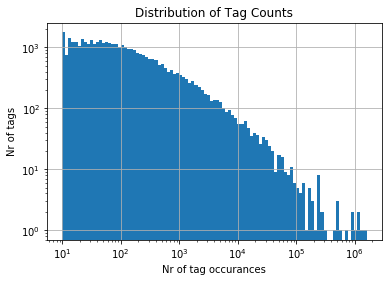

In [11]:
# plotting the histogram
tag_pandas.hist(bins=np.logspace(np.log10(10),np.log10(1600000), 100), log=True)
plt.xscale("log")
plt.xlabel('Nr of tag occurances')
plt.ylabel('Nr of tags')
plt.title('Distribution of Tag Counts')
plt.show()

We use a log-log plot, because some tags are used very often (e.g. "javascript"), but a lot of tags are used only a couple of times. We can observe what we also observed in the last question; many tags are used only a couple of times. However, some tags are used very often, we suspect them to be more general.

We used logarithmic bins since we wanted them to visually take the same space on the plot.

____________________________
3) Plot a bar chart with the number of questions for the 10 most popular tags.

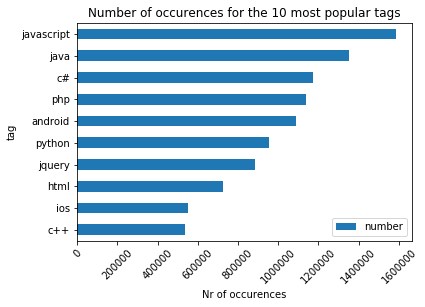

In [12]:
# rename columns and sort by popularity
tag_pandas.columns = ['tag','number']
tag_pandas = tag_pandas.set_index('tag')
tag_pandas = tag_pandas.sort_values(by=['number'])

# plot 10 most popular tags
tag_pandas.tail(10).plot.barh()
plt.xlabel('Nr of occurences')
plt.title('Number of occurences for the 10 most popular tags')
plt.xticks(rotation=45)
plt.show()

We can see that the most popular tags are more general terms, mostly programming languages. This confirms our suspicion from the previous question.

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

___
1)  Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.

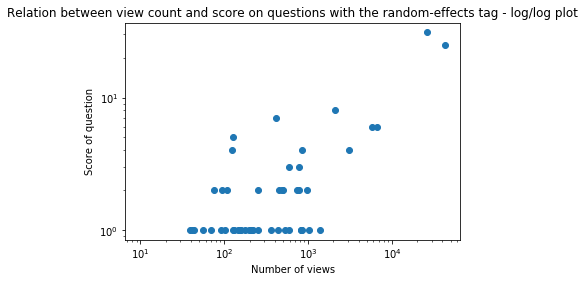

In [13]:
# Keep questions with tag 'random-effects', only keep viewcount and score'
rand_eff_questions = questions.select(['ViewCount', 'Score']).where("Tags like '%random-effects%'")
rand_eff_pandas = rand_eff_questions.toPandas()

# Plot the results
plt.plot(rand_eff_pandas['ViewCount'], rand_eff_pandas['Score'], 'o')
plt.xlabel('Number of views')
plt.ylabel('Score of question')
plt.xscale('log')
plt.yscale('log')
plt.title('Relation between view count and score on questions with the random-effects tag - log/log plot')
plt.show()

We use a log-log plot because the 2 outliers makes the linear plot hard to read.

It is quite difficult to make any conclusion only based on the plot. There are not a lot of points, and the slight tendancy to have high score for high number of views may not be significant.

___
2) Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

In [14]:
# Compute the pearson coefficient
rand_eff_pandas.corr(method='pearson')

ViewCount     Score
ViewCount   1.000000  0.882197
Score       0.882197  1.000000

The Pearson coefficient shows that there is indeed a correlation between the two variables.

We can easily explain this relation betwen the number of views and the score of the question. The higher the score for a question is, the more likely it is to be put on the front page of stackoverflow / shared more (i.e. more views). The opposite is also true, if there are more views on a question, more people might have given it a +1.

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
4. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


___
#### Initial treatment of the data for the task

In [15]:
# For each question, split the tags into multiple (Question, Tag) rows
questions_tags = questions.select(f.split(questions.Tags,'><').alias('tag_names'), 
            f.posexplode(f.split(questions.Tags,'><')).alias('pos', 'val'), 'Id', 'CreationDate').drop('tag_names','pos')\
            .withColumn('val',f.regexp_replace('val','<|>',''))

# Register tables to use them inside SQL queries
questions_tags.registerTempTable('questions_tags')
answers.registerTempTable('answers')

In [16]:
# Query:
# 1. Inner join each question with its fastest answer
# 2. Compute the fastest response time for each (question, fastest_answer) 
# 3. Clean results by removing values with negative or null response time
# 4. Order the results by their fastest response time
query = """
SELECT val Tag, (d2.CreationDate - d1.CreationDate) FastestResponse
FROM questions_tags d1 INNER JOIN
    (SELECT MIN(CreationDate) as CreationDate, ParentId FROM answers GROUP BY ParentId) d2
    ON d1.Id = d2.ParentId
WHERE d2.CreationDate > d1.CreationDate
ORDER BY fastestResponse ASC
"""

# Since the results will be used multiple time, we have it persisted
res = spark.sql(query).persist()
res.registerTempTable('res')

___
1) Get the response time for the first answer of the questions with the tags python and java.

In [17]:
# Only keep questions with tags python (respectively java), and put them in pandas dataframes
res_pandas_python = res.where("Tag = 'python'").toPandas()
res_pandas_java = res.where("Tag = 'java'").toPandas()

# Show the data
print("Some response times for python")
print(res_pandas_python.head(5))
print("\nSome response times for java")
print(res_pandas_java.head(5))

Some response times for python
      Tag  FastestResponse
0  python            0.124
1  python            0.140
2  python            0.140
3  python            0.140
4  python            0.186

Some response times for java
    Tag  FastestResponse
0  java            0.140
1  java            0.143
2  java            0.173
3  java            0.187
4  java            0.233


___
2) Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

In [18]:
# Remove values that are probably incorrect (< 5 sec of response time) to have cleaner results
res_pandas_python = res_pandas_python[res_pandas_python['FastestResponse'] > 5]
res_pandas_java = res_pandas_java[res_pandas_java['FastestResponse'] > 5]

print("Distribution of response time for python")
print(res_pandas_python.describe())
print("\nDistribution of response time for java")
print(res_pandas_java.describe())

Distribution of response time for python
       FastestResponse
count     8.278310e+05
mean      9.837374e+05
std       6.908496e+06
min       6.567000e+00
25%       4.254250e+02
50%       1.357030e+03
75%       9.583383e+03
max       2.464575e+08

Distribution of response time for java
       FastestResponse
count     1.176787e+06
mean      9.989019e+05
std       7.133156e+06
min       5.146000e+00
25%       3.961565e+02
50%       1.224294e+03
75%       9.615602e+03
max       2.985367e+08


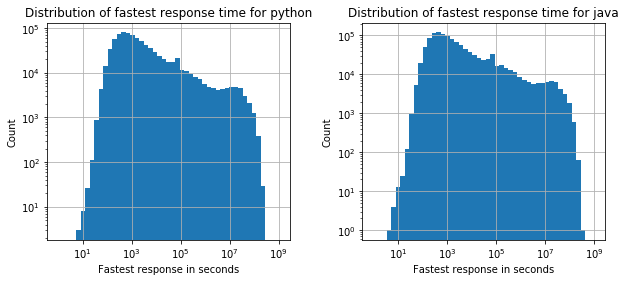

In [19]:
ig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

res_pandas_python.hist(bins=np.logspace(0, 9), ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Fastest response in seconds')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of fastest response time for python')

res_pandas_java.hist(bins=np.logspace(0, 9), ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Fastest response in seconds')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of fastest response time for java')

plt.show()

We chose to plot the response times as a histogram, since this way we can observe the underlying distribution. If we compare the statistics, we see that the mean values are very similar (with java being slightly slower). The standard deviations are almost the same. When looking at the median, java seems to get slightly faster responses. Since the distributions are not normal (they look more like the sum of 2 normals), we use the median as our statistic for the following questions.

We can observe a small spike at ~10⁵ seconds which corresponds to about 24 hours. An explanation for this phenomena could be that StackOverFlow advertise questions without answers a day after they have been asked.

___
3) We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

In [20]:
def bootstrap_median(df, column, n):
    '''
    Calculate the Bootstrap median of a population.
     :param df: dataframe containing values of which to take bootsrapped median
     :param column: string containg name of column to take bootsrapped median from
     :param n: number of iterations to run bootstrap
     :return: numpy array with bootstrapped medians
    '''
    medians = np.zeros(n)
    for i in range(n):
        medians[i] = df[column].sample(n=df.shape[0], replace=True).median()
    return medians

In [21]:
# Runs bootstrap using 1000 iteration for python (respectively java) to compute medians
medians_java = bootstrap_median(res_pandas_java, 'FastestResponse', 1000)
medians_python = bootstrap_median(res_pandas_python, 'FastestResponse', 1000)

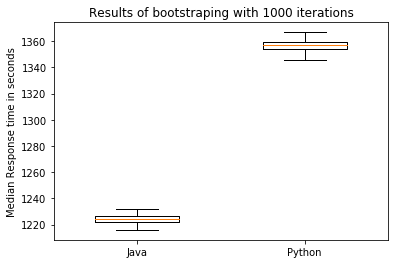

In [22]:
# Show the results inside box plots
plt.boxplot([medians_java, medians_python], 0, sym='', autorange=True, widths=0.5, labels=['Java', 'Python'])
plt.title("Results of bootstraping with 1000 iterations")
plt.ylabel('Median Response time in seconds')
plt.show()

We chose to use the median since it gives a simple answer to the question 'Will I wait longer than x seconds'. It is also better for a "logarithmic/power law" distribution, where there are some really big values that will bias the mean, whereas the median will not have this problem.

If we just compare the two medians, we will not be able to make any informed statement, since they will never be exactly the same due to randomness. We therefore use bootstrapping to get confidence intervals for the response times. If these confidence intervals do not overlap, we can say with high certainty that the medians are different. However the difference is only ~10%. 

___
4) Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

In [23]:
#Query:
# Median function does not exist natively in SQL so we had to do it using a complex subQuery
# 1. Compute the median of the fastest responses for each tag
# 2. Count the number of questions (with answers) for each tag
query = """
SELECT
   x.Tag,
   AVG(FastestResponse) as median,
   y.count
FROM
(
   SELECT
      Tag,
      FastestResponse,
      ROW_NUMBER() OVER (
         PARTITION BY Tag
         ORDER BY FastestResponse ASC) AS RowAsc,
      ROW_NUMBER() OVER (
         PARTITION BY Tag
         ORDER BY FastestResponse DESC) AS RowDesc
   FROM res
) x INNER JOIN
(
   SELECT
      Tag,
      COUNT(FastestResponse) as count
      FROM res
      GROUP BY Tag
) y ON x.Tag = y.Tag
WHERE
   RowAsc IN (RowDesc, RowDesc - 1, RowDesc + 1)
GROUP BY x.Tag, y.count
ORDER BY median

"""
median_for_tags = spark.sql(query)

In [24]:
# Get the names of the 10 tags with fastest median response time, that have at least 5000 questions with answers
best_median = median_for_tags.filter(median_for_tags['count'] > 5000)
best_10_pd = best_median.take(10)
best_10_names = [x.Tag for x in best_10_pd]
best_10_names

['jquery-selectors',
 'int',
 'char',
 'css-selectors',
 'return',
 'constructor',
 'pointers',
 'syntax',
 'integer',
 'boolean']

In [25]:
# Generate an array with the distributions of response time for the 10 'fastest' languages
distr_best_10 = [res.where("Tag = '" + x + "'").toPandas()['FastestResponse'] for x in best_10_names]

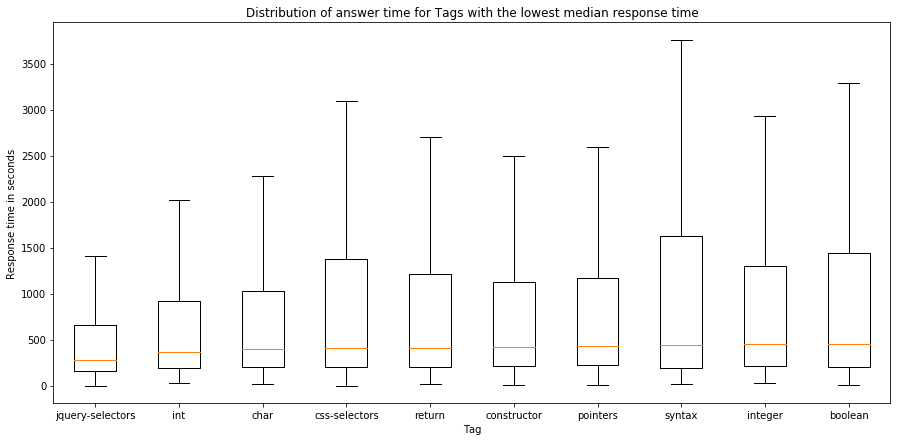

In [26]:
# Show the results
plt.figure(figsize=(15, 7))
plt.boxplot(distr_best_10, 0, sym='',autorange=True, labels=best_10_names)
plt.title('Distribution of answer time for Tags with the lowest median response time')
plt.ylabel('Response time in seconds')
plt.xlabel('Tag')
plt.show()

Here, we chose to reduce the information to a box plot in order to avoid overloding the plot with too much unnecessary information. We see that for the 10 fastest responded tags, the median and minimum response time are very similar. However, the upper tail is very different. For some questions (eg. syntax) we would on average have to wait the same time as others (eg. int), but in the worst case, we would have to wait almost twice as long to get a response.

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?

In [27]:
# Keep question with tag pyspark
pyspark_questions = questions.select('CreationDate').where("Tags like '%pyspark%'")

In [28]:
# 'Hash' function to split all the dates into 30 days bins
div_by_30 = udf(lambda x : int(x / (3600*24*30)))

# Apply the function
pyspark_by_30 = pyspark_questions.select(div_by_30('CreationDate').alias('30_days'))

In [29]:
# Regroup by 30-days period and count
count_by_30 = pyspark_by_30.groupby('30_days').count()

In [30]:
# We now convert to a panda dataframe, sort the data in chronological order, convert fields in the correct format
count_by_30_pd = count_by_30.toPandas()
count_by_30_pd['30_days'] = pd.to_numeric(count_by_30_pd['30_days'])
count_by_30_pd = count_by_30_pd.sort_values(by=['30_days']).reset_index(drop=True)

count_by_30_pd.head(10)

30_days  count
0      539      1
1      542      1
2      544      1
3      545      3
4      546      4
5      547      3
6      548     12
7      549     18
8      550     32
9      551     56

In [34]:
# Get date of the first and latest question
date_min = datetime.utcfromtimestamp(pyspark_questions.orderBy(pyspark_questions.CreationDate.asc()).take(1)[0][0])
date_max = datetime.utcfromtimestamp(pyspark_questions.orderBy(pyspark_questions.CreationDate.desc()).take(1)[0][0])

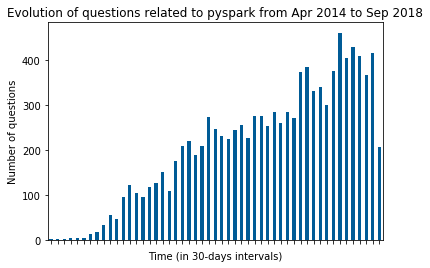

In [35]:
# And now we plot
plot = count_by_30_pd['count'].plot.bar(color="#005b96")
plot.axes.set_xticklabels([])
plt.ylabel('Number of questions')  
plt.xlabel('Time (in 30-days intervals)')
plt.title('Evolution of questions related to pyspark from ' +\
          date_min.strftime("%b") + ' ' + str(date_min.year) + ' to ' + date_max.strftime("%b") + ' ' + str(date_max.year))
plt.show()

There is clearly an increase in interest for pyspark over time, wich is completly expected. A new usefull library will msot of the time gain popularity, at least while there is not an alternative that comes and try to do better.

The lower value for the last month is probably due to the fact that the data was recolted in the 'middle' of a mouth, so 'half' of that month's questions havn't been asked yet.

In [36]:
count_by_30_pd.corr(method='pearson')

30_days     count
30_days  1.000000  0.946469
count    0.946469  1.000000

Using the pearson coefficient, it confirms our intuition, there is indeed a correlation between the two variables.